# Paper: Monoids: Themes and Variations

This notebook is to reproduce the work in the article "Monoids: Theme and Variations".

In [5]:
using Pkg
Pkg.activate(".")
using GeometryBasics
using PlotlyJS
using LinearAlgebra
using CoordinateTransformations
using Rotations
import FunctionWrappers: FunctionWrapper

"""
FunctionType(domain::Type, codomain::Type)
Returns a type for functions from `domain`
to `codmain`. This can be used to enforce
correct composition of functions.
"""
function FunctionType(domain::Type, codomain::Type)
    FunctionWrapper{codomain,Tuple{domain}}
end;

  Activating project at `~/MEGA/EMAP/Julia_Tutorials/CategoryTheory`
[ Info: Precompiling GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326]
[ Info: Precompiling PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]


WebIO._IJuliaInit()

[ Info: Precompiling CoordinateTransformations [150eb455-5306-5404-9cee-2592286d6298]
[ Info: Precompiling Rotations [6038ab10-8711-5258-84ad-4b1120ba62dc]
[ Info: Precompiling FunctionWrappers [069b7b12-0de2-55c6-9aab-29f3d0a68a2e]


## 1. What is a Diagram?

The first question is how de we define a "Diagram". A simple description
is that a diagram is an *ordered collection of primitives*.

A primitive is any thing that we know how to draw. For example, if we are using SVG,
then our primitives includes things like lines, rectangles, circles ,ellipses, Bézier curves, and so on.

The order of the primitive defines which one is in top of the other.
We can note that a list with a concatenation operation creates a *monoid*. Hence,
we can say that a Diagram as such is a monoid.

## 2. A Diagram is a Monoid

A monoid is a category composed of a single object (type), a neutral element and an operator, e.g. $(M,e,\otimes)$.
In programming, $M$ is a type, $\otimes$ is a function with two arguments of type $M$, and $e$ is a value of type $M$;

Thus, consider $M$ to be the set of ordered list of primitives of type `Primitive`.
For two diagrams $D_1 = [p^{(1)}_1,...,p^{(1)}_n]$ and
$D_2 = [p^{(2)}_1,...,p^{(2)}_m]$, we have

$$
D_1 \otimes D_2 = 
[p^{(1)}_1,...,p^{(1)}_n,p^{(2)}_1,...,p^{(2)}_m].
$$

Note that the empty list `[]` is the null element. We can also show that this composition operation is associative.
Thus, the ordered list of primitives with concatenation operator does indeed defines a **monoid**.

Let's code this.
First, we'll define our primitives using the `GeometryBasic.jl` package. It already
provides the primitives we want. Yet, we can also define them manually.

In [6]:
abstract type Primitive1 end
struct Prim{T<:AbstractGeometry} <: Primitive1
    g::T
end

struct MyCircle <: Primitive1
    ρ::Real
    c::Point2
    g::Circle
    function MyCircle(ρ=1,c=Point(0,0)) 
        if ρ < 0
            error("ρ should be greater or equal than 0.")
        end
        return new(ρ, c, Circle(c,ρ))
    end
end

struct MySquare <: Primitive1
    l::Real
    c::Point2
    g::AbstractGeometry
    function MySquare(l=1,c=Point(0,0)) 
        if l < 0
            error("length should be greater or equal than 0.")
        end
        pts = [c + Point(l/2,l/2), c + Point(-l/2,l/2), c + Point(-l/2,-l/2), c + Point(l/2, -l/2)]
        return new(l, c, Polygon(pts))
    end
end

# Base.@kwdef struct MyPoint <: Primitive1
#     p::Point = Point(0,0)
# end

struct Diagram1
    p::Vector{Primitive1}
end
Diagram1(p::Primitive1=[]) = Diagram1([p])

neutral(::Type{Diagram1}) = Diagram1(Primitive1[])

⋄(p::Vector{Primitive1}, q::Vector{Primitive1}) = vcat(p,q)
⋄(d1::Diagram1, d2::Diagram1) = Diagram1(d1.p ⋄ d2.p)


⋄ (generic function with 2 methods)

In [7]:
circle = MyCircle(1, Point(0,0))
D = Diagram1([circle])

D.p == (Diagram1() ⋄ D).p

true

Here are some functions that can help working with a diagram. 

In [8]:
unD(d::Diagram1) = d.p
prim(p::Primitive1) = Diagram1([p])

prim (generic function with 1 method)

In [9]:
d = Diagram1(MyCircle(2)) ⋄ Diagram1(MyCircle(1));

d.p[1],d.p[2]

(MyCircle(2, [0, 0], Circle{Int64}([0, 0], 2)), MyCircle(1, [0, 0], Circle{Int64}([0, 0], 1)))

There is a *practical* issue with our `Diagram1` definition. Suppose we have diagrams
`d1 = [p1]`, `d2 = [p2]`, `d3 = [p3]`. One now wishes to draw `d1` over `d2` and over `d3`. We could think
that `d1 ⋄ (d2 ⋄ d3)` would do the job, but this is actually putting `d1` under the other two.
Remember that `⋄` is just concatenation, hence:
```
julia> d1 ⋄ (d2 ⋄ d3)
[p1,p2,p3]
```
When we draw `[p1,p2,p3]`, we first draw `p1`, i.e. under the other two.

We can change the order to this by defining a dual of `Diagram1`.

In [10]:
struct DiagramDual
    p::Vector{Primitive1}
end
DiagramDual(p::Primitive1=[]) = DiagramDual([p])
neutral(::Type{DiagramDual}) = DiagramDual([])
⋄(d1::DiagramDual, d2::DiagramDual) = DiagramDual(d2.p ⋄ d1.p)
mconcat(ds::Vector{T}) where T = foldr(⋄,ds; init=neutral(T))
unD(d::DiagramDual) = d.p

unD (generic function with 2 methods)

This is now a **contravariant functor**.

In [11]:
circle = MyCircle()
square = MySquare()
triangle1 = Prim(Triangle(Point(0,0),Point(1,1), Point(1,0)))
triangle2 = Prim(Triangle(Point(0,0),Point(-1,-1), Point(-1,0)))

D1 = DiagramDual(circle)
D2 = DiagramDual(square)
D3 = DiagramDual([triangle1, triangle2])

D = D1 ⋄ D2 ⋄ D3;

In [12]:
D.p[1] == D1.p[1], D.p[1] == D3.p[1]

(false, true)

In [13]:
D = mconcat([D1,D2,D3]);

In [14]:
D.p[1] == D1.p[1], D.p[1] == D3.p[1]

(false, true)

Note that now that the order follows the "desired" drawing order. 

Let's plot our diagram. We know how to draw each primitive, we just
need to iteratively plot each one.

In [15]:
function plotgeometry(g::AbstractGeometry; kwargs...)
    x = coordx(g)
    y = coordy(g)
    x = vcat(x,x[1])
    y = vcat(y,y[1])
    scatter(x=x,y=y; kwargs...)
end

function plotgeometry(p::Primitive1; kwargs...)
    plotgeometry(p.g)
end
coordx(t::AbstractGeometry) = [x[1] for x in coordinates(t)]
coordy(t::AbstractGeometry) = [x[2] for x in coordinates(t)]

coordy (generic function with 1 method)

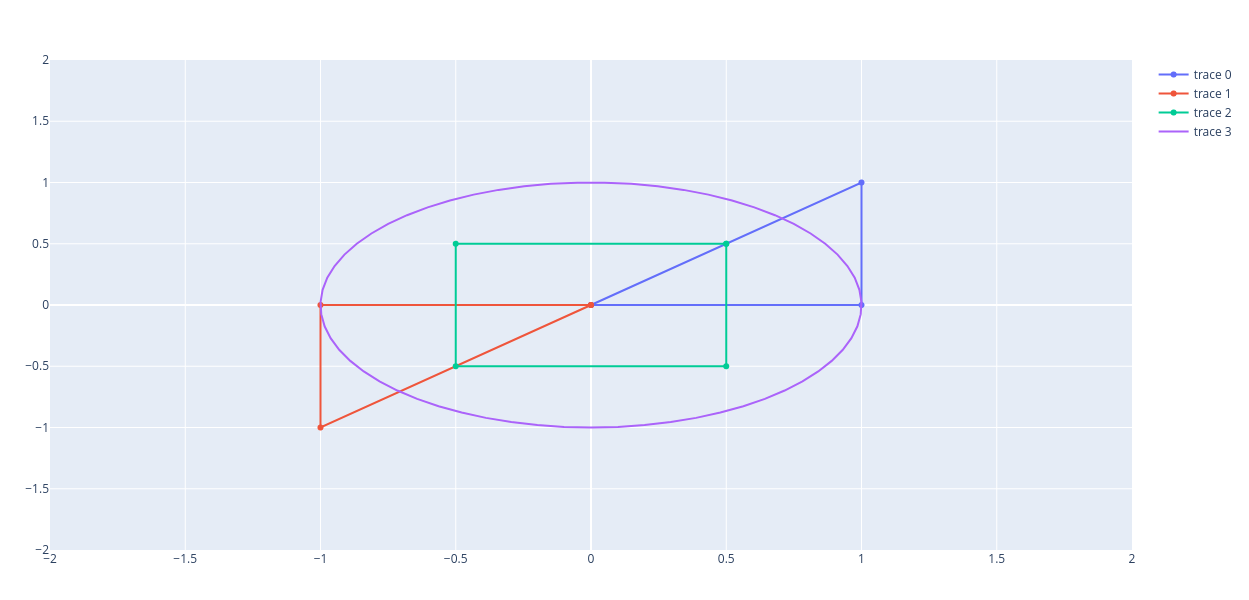

In [16]:
function plotgeometry(D::DiagramDual; kwargs...)
    map(plotgeometry,D.p)
end

 layout = Layout(
    xaxis = attr(range = [-2, 2]),
    yaxis = attr(range = [-2, 2]),
    width = 600,
    height = 600
)


plot(plotgeometry(D),layout)

## 3. Envelopes

Our Diagram can compose primitives. But we want to be able to do more complicated drawings.
For example, we might want to "glue" two primitives side by side.
To be able to do this, we need to know how much one primitive should be translated until it
touched only the "border" of the other.

Thus, it would be necessary to be able to compute this distance for each primitive.
This is what the author of the paper has called an *envelope*.

The envelope is a functional defined for each primitive, with
$env: V_2 \to \mathbb R$ where $V_2$ is a 2D vector.
This means that, when we define a primitive, we must also define it's envelope funciton.

**Def.(Envelope)** Given a diagram $D$ and a direction $v$,
$$
env_D(v) := \sup_{u \in D}\frac{\langle u,v\rangle}{||v||^2}.
$$

We call $\sup_{u \in D}\langle u,v\rangle$ the *support* function.

The nice thing about the envelope functional is that the envelope of a diagram $D = [p_1,p_2,...,p_n]$
is just $\max\{env(p_1),...,env(p_n)\}$, i.e. once we know how to compute the envelope of the primitives,
the envelope for the diagram can easily be found.

Let's use the `GeometricBasics.jl` package to define our primimtives. This package
has some geometric objects implemented, and some useful functionalities.

An envelope type is a function taking a vector $V_2$  to $\mathbb R$.
Again this works as a monoid. Note, the set of envelope functions is defined
by one envelope function for each primitive. Thus, $envelopeP::\text{Prim} \to \text{Envelope}$
where $env::\text{Envelope}$ is $env:V_2 \to \mathbb R$.

In [17]:
# support(p::Primitive1,v::Vector) = support(p.g,v)
# support(t::AbstractGeometry,v::Vector) = mapreduce(p->dot(p,v),max,coordinates(t))

# envelope(p::Primitive1, v::Vector) = support(p,normalize(v))
# envelope(t::AbstractGeometry, v::Vector) = support(t,normalize(v))
function envelopeP(t::AbstractGeometry, v::Vector)
    v = normalize(v)
    mapreduce(p->dot(p,v),max,coordinates(t))
end
envelopeP(p::Primitive1, v::Vector) = envelopeP(p.g,v)

# Lifting function for Diagram. Note that returns `nothing` for the empty Diagram
# Hence, `envelope` returns `x::Option{Nothig, Real}`
envelope(D::DiagramDual, v::Vector) = !isempty(D.p) ? mapreduce(x->envelopeP(x,v),max, D.p) : nothing

transform(g::AbstractGeometry,T) = Polygon(map(T,coordinates(g)))


function plotenvelopeP(g::Primitive1;name="envelope", kwargs...)
    θs = 0:0.05:2π
    vs = [[cos(θ), sin(θ)] for θ in θs]
    envs = hcat([envelopeP(g,i)i for i in vs]...);
    scatter(x= envs[1,:],y = envs[2,:]; name = name, kwargs...)
end
function plotenvelope(g::DiagramDual;name="envelope", kwargs...)
    θs = 0:0.05:2π
    vs = [[cos(θ), sin(θ)] for θ in θs]
    envs = hcat([envelope(g,i)i for i in vs]...);
    scatter(x= envs[1,:],y = envs[2,:]; name = name, kwargs...)
end

plotenvelope (generic function with 1 method)

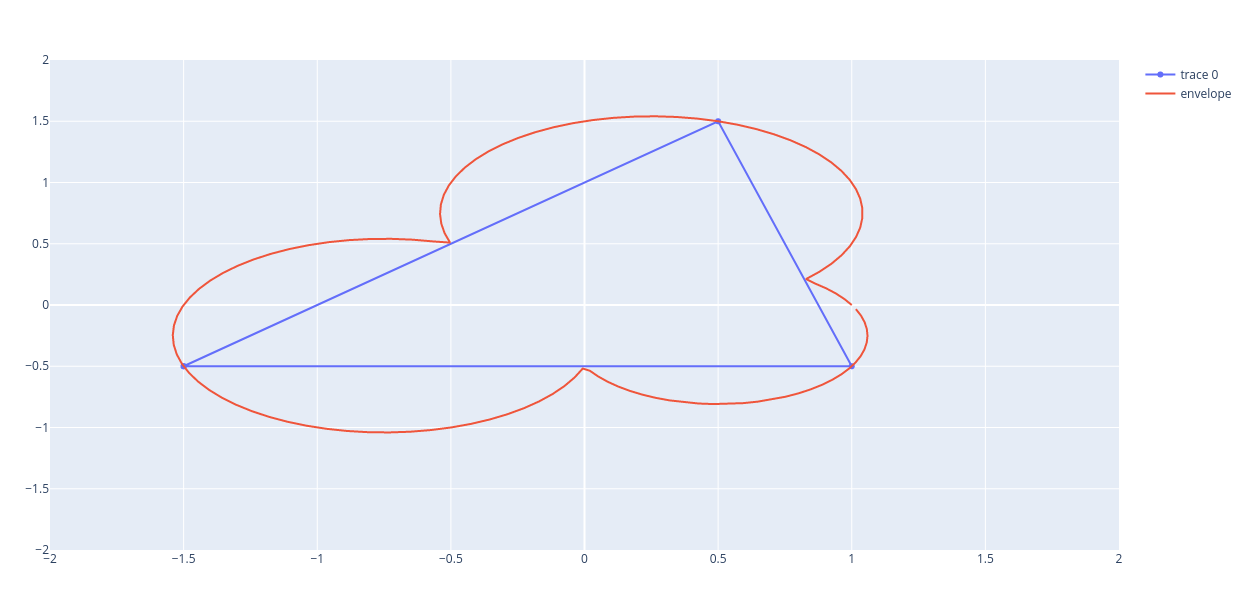

In [18]:
a = Point(-1.5,-0.5)#+Point(10,10)
b = Point(0.5,1.5)
c = Point(1.0,-0.5)
t = Triangle(a,b,c)

pt = plotgeometry(t)
pe = plotenvelopeP(Prim(t))
plot([pt,pe], layout)

Our function for the envelope works on our primitives, but we need to extend it for the actual diagrams.

As we've said, it's a simple max over all envelopes.

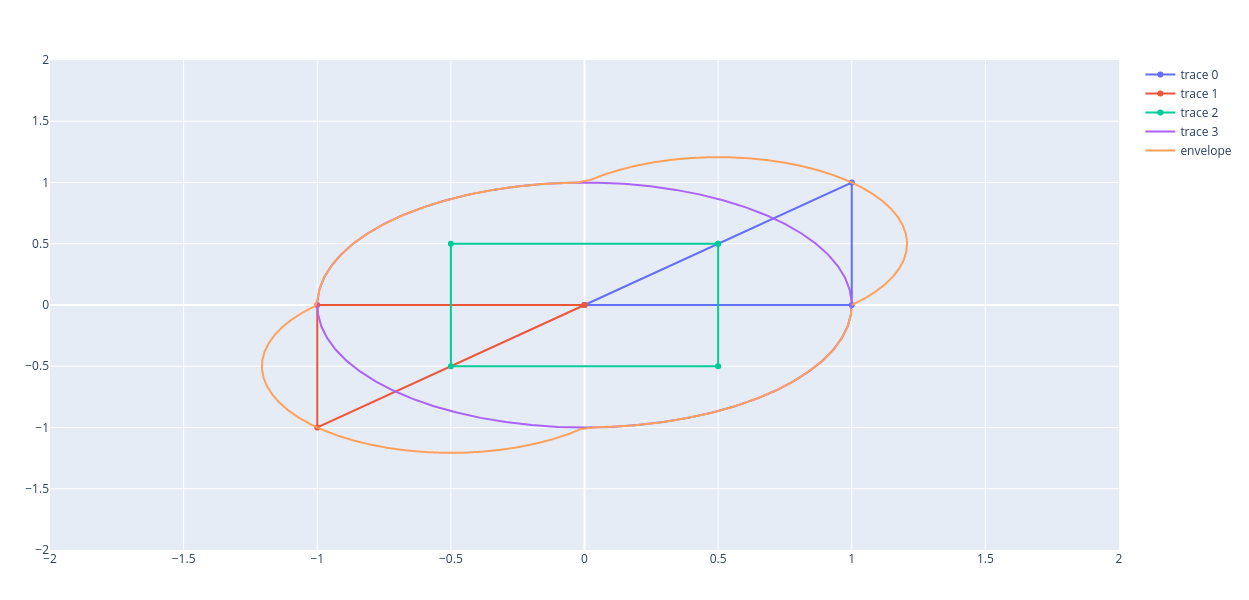

In [15]:
D = D1 ⋄ D2 ⋄ D3

pD = plotgeometry(D)
pe = plotenvelope(D)

plot(vcat(pD,pe), layout)

## 3. Trace

The trace is in a sense the dual of an evelope. The trace is the smallest distance from a point until the geometric object.

In [16]:
function traceG(g::AbstractGeometry, v)
    ρ = mapreduce(norm, max, coordinates(g))
    v = normalize(v)
    ray = ρ*v
    ray = Line(Point(0.0,0.0),Point(ray...))
    
    # Collecting line segments of geometry
    pts = collect(coordinates(g))
    L = length(pts)
    pts = push!(pts,pts[1])

    lines = []
    for i in 1:L
        push!(lines,Line(pts[i], pts[i + 1]))
    end
    
    inter = map(x->intersects(x,ray),lines)
    if mapreduce(x->x[1], +, inter) == 0 return Inf end
    
    mapreduce(x-> !x[1] ? Inf : norm(x[2]), min, inter)
end

function traceP(p::Primitive1, v)
    traceG(p.g,v)
end

function trace(D::DiagramDual, v)
    mapreduce(x->traceP(x,v),min,D.p)
end

trace (generic function with 1 method)

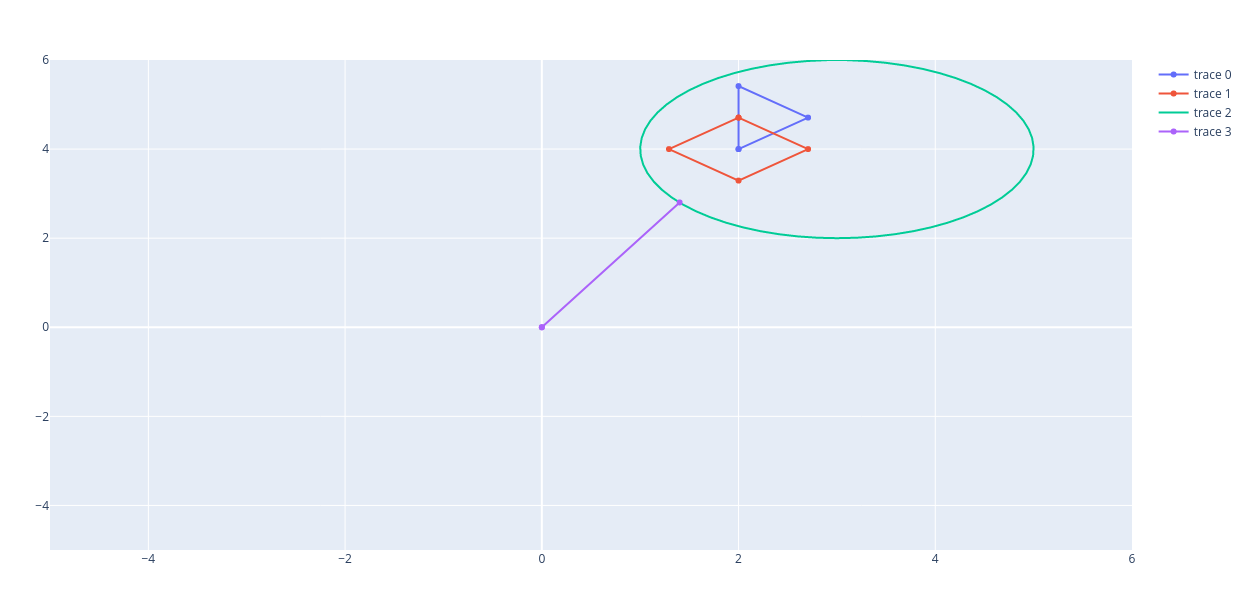

In [17]:
R = LinearMap(RotMatrix{2}(π/4))
T = Translation(2.0, 4.0)
s = MySquare(1).g
t = Triangle(Point(0,0), Point(1,0), Point(1,1))
c = Circle(Point(1,0),2)

st = transform(t,T∘R)
ss = transform(s,T∘R)
sc = transform(c,T)
D  = DiagramDual(Prim.([st,ss,sc]))


v = [2.0,4.0]
v = normalize(v) * trace(D,v)

l = Line(Point(0.0,0.),Point(v...))

layout = Layout(
    xaxis = attr(range = [-5, 6]),
    yaxis = attr(range = [-5, 6]),
    width = 600,
    height = 600
)
pt = plotgeometry(D)
pl = plotgeometry(l)

plot(vcat(pt,pl),layout)

## 5. Envelope and Trace as Semigroups / Monoids

We explained how these two functions are defined, let us explain the categorical
interpratation.

First, a semigroup $(S, \circ)$ is a set $S$ with an associative binary operation $\circ$,
i.e. a semigroup is just a monoid without a neutral element.
The tuple $(\mathbb R, max)$ is a semigroup. Just note that for $a,b \in \mathbb R$,
$max(a,max(b,c)) = max(max(a,b),c)$.

Consider a type `Envelope` containing functions that go from vectors
to real numbers, i.e. a type that contains envelope functions.

We can define a semigroup `(Envelope, ⋄)` where
the composition of two envelope functions return another
evelope fuction as  `max(env1, env2)` 

In [18]:
struct Envelope1
    f::FunctionType(Vector{Real},Real)
end

function ⋄(env1::Envelope1, env2::Envelope1)::Envelope1
    Envelope1(FunctionType(Vector{Real},Real)(x::Vector{Real} -> max(env1.f(x),env2.f(x))))
end

envP(p::Primitive1) = Envelope1(v -> envelopeP(p.g,v))
envP(MyCircle()) isa Envelope1

true

In [19]:
envP(MyCircle()) ⋄ envP(MyCircle(2)) isa Envelope1

true

In [20]:
(envP(MyCircle()) ⋄ envP(MyCircle(2))).f([1,1])

1.9986014095767968

We can turn the semigroup `(Envelope, ⋄)` into a monoid if we define an empty envelope
function `env_empty(v::Vector) = nothing`.

In [21]:
# Removing the function wrapper due to compilation erros
struct Envelope
    # f::FunctionType(Vector{Real},Union{Real,Nothing})
    f::Function
end

# Let's create a function `fmax` that can compute the max when there are `nothing` values.
fmax(x,y) = max(x,y)
fmax(x,y::Nothing) = x
fmax(x::Nothing,y) = y
fmax(x::Nothing,y::Nothing) = nothing
function ⋄(env1::Envelope, env2::Envelope)::Envelope
    Envelope(x -> fmax(env1.f(x),env2.f(x)))
end
neutral(::Type{Envelope}) = Envelope(v::Vector -> nothing)


envP(p::Primitive1) = Envelope(v -> envelopeP(p.g,v))
envP() = Envelope(v::Vector -> nothing)

(envP(MyCircle()) ⋄ envP()).f([1,1]) ≈ envP(MyCircle()).f([1,1]), (envP() ⋄ envP(MyCircle(2))).f([1,1]) ≈ envP(MyCircle(2)).f([1,1])

(true, true)

Finally, let's implement the `env` function, which is the same as
the  `envelope`, but it is actually a high-order function. 

In [22]:
envD(D::DiagramDual) = (mconcat ∘ map)(envP,unD(D))
envD(D).f([1,2]) == envelope(D,[1,2])

true

### Defining `beside` 

With the envelope working, let us define the `beside` operation.
This consists in translating a primitive by the 

In [23]:
translateP(C::MyCircle,v::Vector) = MyCircle(C.ρ, C.c + Point2(v))
translateP(S::MySquare,v::Vector) = MySquare(S.l, S.c + Point2(v))
translateP(p::Prim,v::Vector) = Prim(transform(p.g,Translation(v)))


# Usage
translateP(triangle1,[1,1]);
translateP(MySquare(),[1,0])
translateP(MyCircle(),[1,2])

# Lift to Diagram
translate(d::DiagramDual, v) = DiagramDual(map(x->translateP(x,v), d.p))

translate (generic function with 1 method)

In [24]:
D1 = DiagramDual([MyCircle(),MyCircle(2)])
D2 = DiagramDual(MySquare(2));

In [25]:
function beside(D1::DiagramDual, D2::DiagramDual, v::Vector)::DiagramDual
    e1 = envD(D1).f(v)
    e2 = envD(D2).f(-v)
    if isnothing(e1) || isnothing(e2)
        return D1 ⋄ D2
    end
    D1 ⋄ translate(D2, (e1+e2)*v)
end

beside (generic function with 1 method)

In [26]:
# Does nothing
beside(D1,DiagramDual(),[1,0])

DiagramDual(Primitive1[MyCircle(1, [0, 0], Circle{Int64}([0, 0], 1)), MyCircle(2, [0, 0], Circle{Int64}([0, 0], 2))])

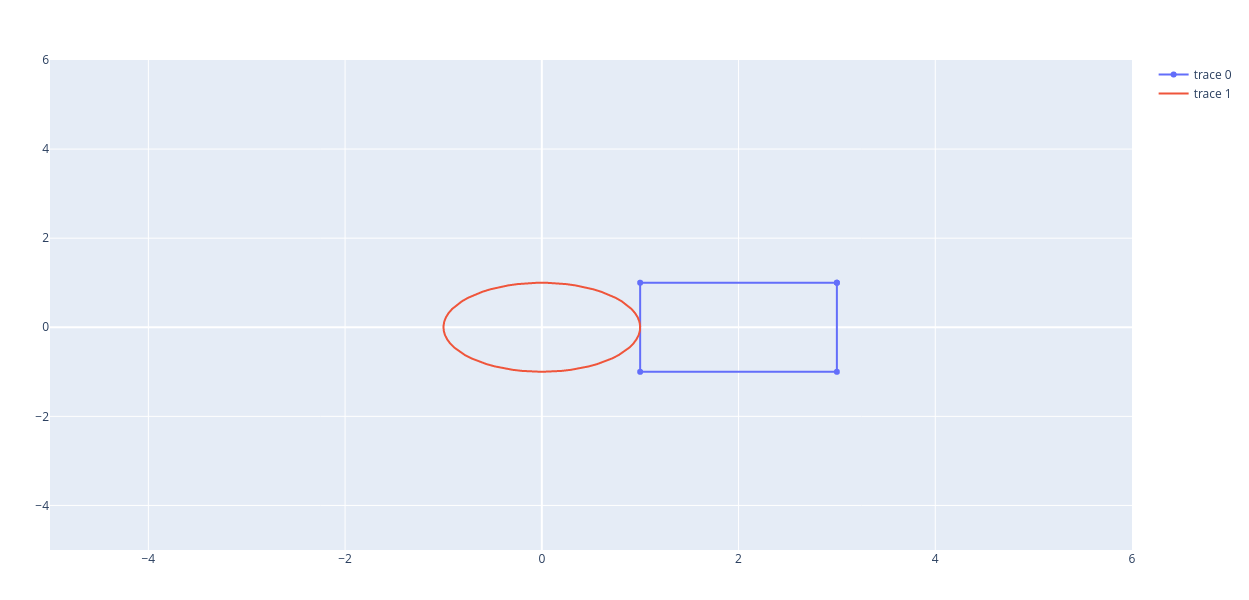

In [27]:
D1 = DiagramDual(MyCircle())
D2 = DiagramDual(MySquare(2));
D3  = beside(D1,D2,[1,0])

function plotgeometry(D::DiagramDual; kwargs...)
    map(plotgeometry,D.p)
end

p = plotgeometry(D3)
plot(p,layout)

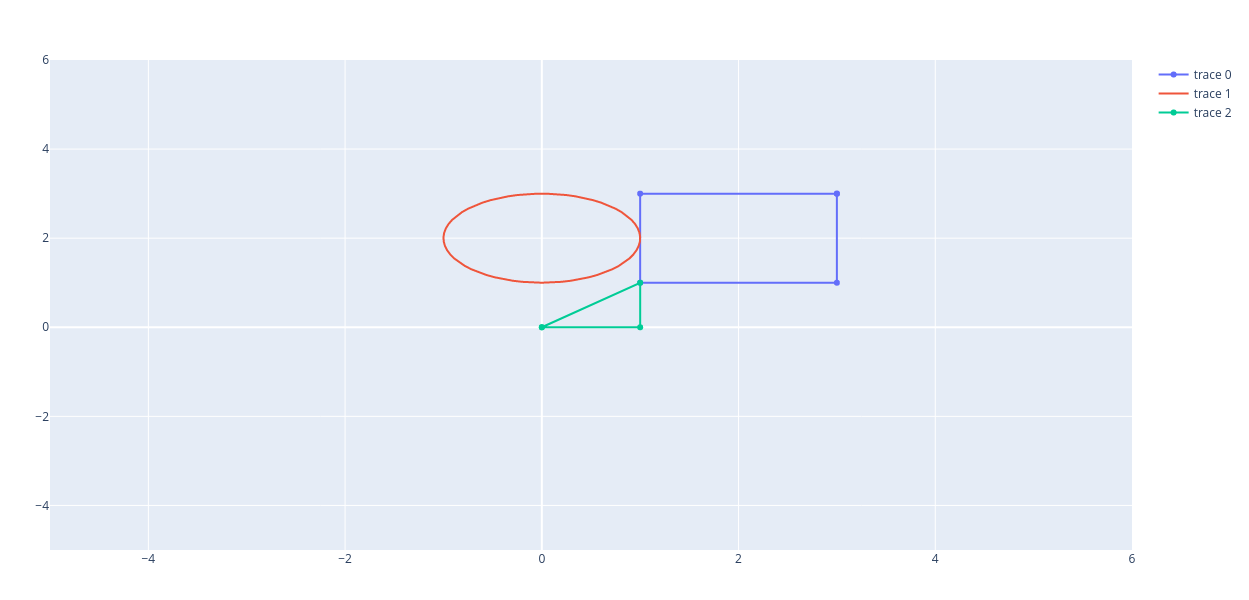

In [28]:
D1 = DiagramDual(MyCircle())
D2 = DiagramDual(MySquare(2));
D3 = DiagramDual(Prim(Triangle(Point(0,0),Point(1,1), Point(1,0))))

D  = beside(D3,beside(D1,D2,[1,0]),[0,1])
p = plotgeometry(D)
plot(p,layout)

## Caching Envelopes

We have two monoids, `(Envelope, envP(),⋄)` and `(Diagram, [],⋄)`.
Remember the the product of monoids also defines a monoid. Hence, we can
redefine the `Diagram` as a tuple `([Prim],Envelope)`.

In [29]:
struct Diagram2
    p::Vector{Primitive1}
    e::Envelope
end
fnothing(x) = nothing

Diagram2(p::Primitive1) = Diagram2([p],envP(p))
Diagram2(p::Primitive1,e::Envelope) = Diagram2([p],e)
Diagram2() = Diagram2([],Envelope(fnothing))
Diagram2(p::Vector{<:Primitive1}) = Diagram2(p,mconcat(map(envP,p)))

neutral(::Type{Diagram2}) = Diagram2()
⋄(d1::Diagram2, d2::Diagram2) = Diagram2(d2.p ⋄ d1.p,d2.e ⋄ d1.e)
D1 = Diagram2(MyCircle())
D2 = Diagram2(MyCircle(2))

translate(d, v) = Diagram2(map(x->translateP(x,v), d.p))
function beside(D1, D2, v::Vector)::Diagram2
    e1 = D1.e.f(v)
    e2 = D2.e.f(-v)
    if isnothing(e1) || isnothing(e2)
        return D1 ⋄ D2
    end
    D1 ⋄ translate(D2, (e1+e2)*v/norm(v))
end

beside (generic function with 2 methods)

In [30]:
# [MyCircle()] isa Vector{<: Primitive1}
Diagram2([MyCircle()])

Diagram2(Primitive1[MyCircle(1, [0, 0], Circle{Int64}([0, 0], 1))], Envelope(var"#36#37"{Envelope, Envelope}(Envelope(var"#40#41"{MyCircle}(MyCircle(1, [0, 0], Circle{Int64}([0, 0], 1)))), Envelope(var"#38#39"()))))

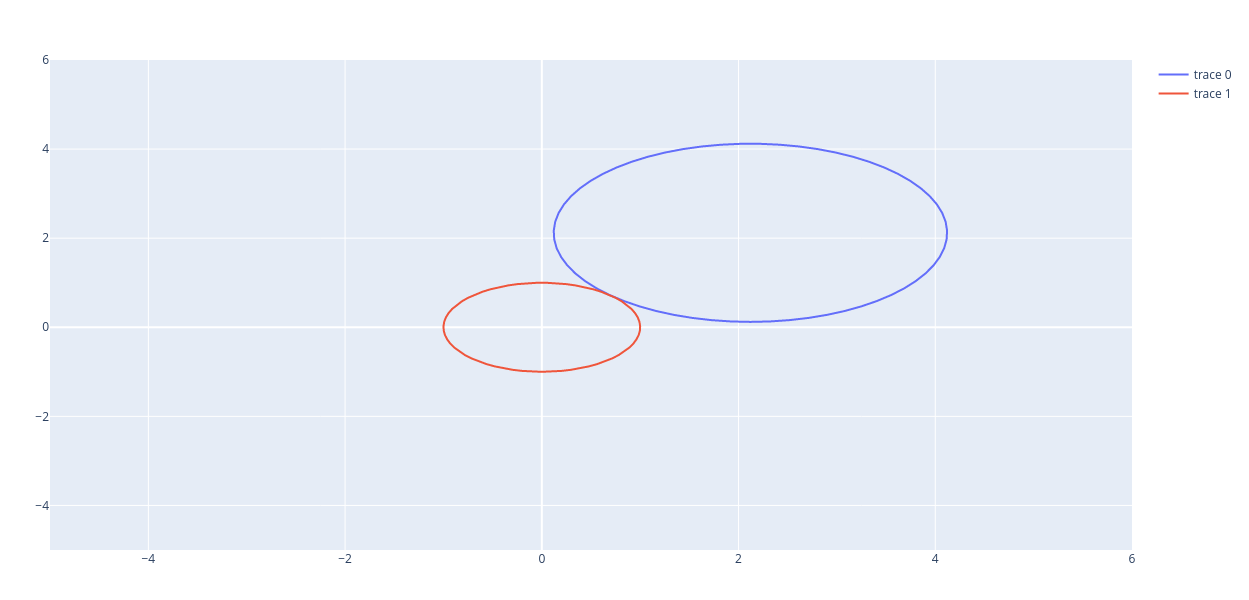

In [31]:
D1 = Diagram2(MyCircle())
D2 = Diagram2(MyCircle(2));
D1 ⋄ D2
D  = beside(D1,D2,[1,1])

function plotgeometry(D::Diagram2; kwargs...)
    map(plotgeometry,D.p)
end

p = plotgeometry(D)
plot(p,layout)

## Caching Trace

Let us repeate the same process for trace.

In [32]:
struct Trace
    f::Function
end

# Let's create a function `fmax` that can compute the max when there are `nothing` values.
fmin(x,y) = min(x,y)
fmin(x,y::Nothing) = x
fmin(x::Nothing,y) = y
fmin(x::Nothing,y::Nothing) = nothing
function ⋄(tr1::Trace, tr2::Trace)::Trace
    Trace(x -> fmin(tr1.f(x),tr2.f(x)))
end
neutral(::Type{Trace}) = Trace(v::Vector -> nothing)

trP(p::Primitive1) = Trace(v -> traceP(p.g,v))
trP() = Envelope(v::Vector -> nothing)

# (envP(MyCircle()) ⋄ envP()).f([1,1]) ≈ envP(MyCircle()).f([1,1]), (envP() ⋄ envP(MyCircle(2))).f([1,1]) ≈ envP(MyCircle(2)).f([1,1])

trP (generic function with 2 methods)

In [33]:
trP()

Envelope(var"#56#57"())

In [34]:
struct Diagram3
    p::Vector{Primitive1}
    e::Envelope
    t::Trace
end
Diagram3(p::Primitive1) = Diagram3([p],envP(p),trP(p))
Diagram3(p::Primitive1,e::Envelope,t::Trace) = Diagram3([p],e,t)
Diagram3() = Diagram3([],Envelope(fnothing), Trace(fnothing))
Diagram3(p::Vector{<:Primitive1}) = Diagram3(p,mconcat(map(envP,p)),mconcat(map(trP,p)))

neutral(::Type{Diagram3}) = Diagram3()
⋄(d1::Diagram3, d2::Diagram3) = Diagram3(d2.p ⋄ d1.p,d2.e ⋄ d1.e,d2.t ⋄ d1.t)

D1 = Diagram3(MyCircle())
D2 = Diagram3(MyCircle(2))

D1 ⋄ D2;

In [35]:
D1 = translate(Diagram3(MyCircle()),[3,3])
D2 = Diagram3(MyCircle(2))
l = Line(Point(0.0,0.),Point(v...))

function plotgeometry(D::Diagram3; kwargs...)
    map(plotgeometry,D.p)
end

p = plotgeometry(D1 ⋄ D2)
plot(p,layout)

LoadError: MethodError: no method matching ⋄(::Diagram2, ::Diagram3)
[0mClosest candidates are:
[0m  ⋄(::Diagram2, [91m::Diagram2[39m) at In[29]:13
[0m  ⋄([91m::Diagram3[39m, ::Diagram3) at In[34]:12

In [36]:
D = D1 ⋄ D2

D.t.f([1,1])

LoadError: MethodError: no method matching ⋄(::Diagram2, ::Diagram3)
[0mClosest candidates are:
[0m  ⋄(::Diagram2, [91m::Diagram2[39m) at In[29]:13
[0m  ⋄([91m::Diagram3[39m, ::Diagram3) at In[34]:12